# Graffiti

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# example of using a pre-trained model as a classifier
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.efficientnet import decode_predictions
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.applications.efficientnet import EfficientNetB7
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from subprocess import check_output
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:

all_class = pd.read_csv("/content/drive/MyDrive/final/all_class.csv")

In [ ]:
x = np.load('/content/drive/MyDrive/final/x.npy')
y = np.load('/content/drive/MyDrive/final/y.npy')

In [ ]:
# x = np.array(list(thing for thing in all_class.values[:,3]))
# y = all_class.values[:,-4:].astype(np.float32)

In [ ]:
y_multiclass = np.argmax(y, axis=1)

In [ ]:
class_counts = np.bincount(y_multiclass)
print(class_counts)

[693 780 240 366]


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
y_train.shape

(1663, 4)

In [ ]:
from tensorflow import convert_to_tensor

x_train = convert_to_tensor(x_train)
y_train = convert_to_tensor(y_train)

x_test = convert_to_tensor(x_test)
y_test = convert_to_tensor(y_test)

In [ ]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.regularizers import l2
# load model without classifier layers

# model = EfficientNetB3(include_top=False, input_shape=(200, 200, 3), pooling='max')
model = EfficientNetB7(include_top=False, input_shape=(400, 400, 3), pooling='max')

# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(512, activation='relu')(flat1)
# class1 = Dense(1024, activation='relu', kernel_regularizer=l2(0.5))(flat1)
# drop1 = Dropout(0.4)(class1)
class1 = Dense(64, activation='relu')(class1)
output = Dense(4, activation='softmax')(class1)
# output = Dense(1, activation='softmax')(output)

model = Model(inputs=model.inputs, outputs=output)

print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 rescaling_10 (Rescaling)    (None, 400, 400, 3)          0         ['input_6[0][0]']             
                                                                                                  
 normalization_5 (Normaliza  (None, 400, 400, 3)          7         ['rescaling_10[0][0]']        
 tion)                                                                                            
                                                                                                  
 rescaling_11 (Rescaling)    (None, 400, 400, 3)          0         ['normalization_5[0][0]'

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy


for layer in model.layers[:-22]:
    layer.trainable = False
# for layer in model.layers[:-23]:
#     layer.trainable = False

optimizer = Adam(learning_rate=0.001, beta_1=0.9)
model.compile(optimizer=optimizer, loss="CategoricalCrossentropy", metrics=['accuracy'])

# model.fit(x_train_tf, y_train_tf, epochs=5)
# model.fit(x_train_tf, y_train_tf, epochs=15, validation_data=(x_val_tf, y_val_tf))

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow import gather

train_losses = []
val_losses = []

kf = KFold(n_splits=3, shuffle=True, random_state=2)
for train_index, val_index in kf.split(x_train, y_train):
    X_train, X_val = gather(x_train, train_index), gather(x_train, val_index)
    Y_train, Y_val = gather(y_train, train_index), gather(y_train, val_index)

    # Train the model
    history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val, Y_val)
    print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}\n')

    # store training and validation loss
    train_losses.extend(history.history['loss'])
    val_losses.extend(history.history['val_loss'])

Epoch 1/10
35/35 [==============================] - 43s 551ms/step - loss: 3.1674 - accuracy: 0.6516 - val_loss: 1.2681 - val_accuracy: 0.6991
Epoch 2/10
35/35 [==============================] - 14s 406ms/step - loss: 0.3119 - accuracy: 0.9097 - val_loss: 0.3021 - val_accuracy: 0.8613
Epoch 3/10
35/35 [==============================] - 14s 404ms/step - loss: 0.1267 - accuracy: 0.9747 - val_loss: 0.2929 - val_accuracy: 0.8883
Epoch 4/10
35/35 [==============================] - 14s 403ms/step - loss: 0.0876 - accuracy: 0.9783 - val_loss: 0.1636 - val_accuracy: 0.9532
Epoch 5/10
35/35 [==============================] - 14s 403ms/step - loss: 0.0745 - accuracy: 0.9819 - val_loss: 0.2018 - val_accuracy: 0.9441
Epoch 6/10
35/35 [==============================] - 14s 405ms/step - loss: 0.0652 - accuracy: 0.9819 - val_loss: 0.2596 - val_accuracy: 0.9261
Epoch 7/10
35/35 [==============================] - 14s 403ms/step - loss: 0.1436 - accuracy: 0.9693 - val_loss: 0.2987 - val_accuracy: 0.9261

ValueError: x and y must have same first dimension, but have shapes (50,) and (30,)

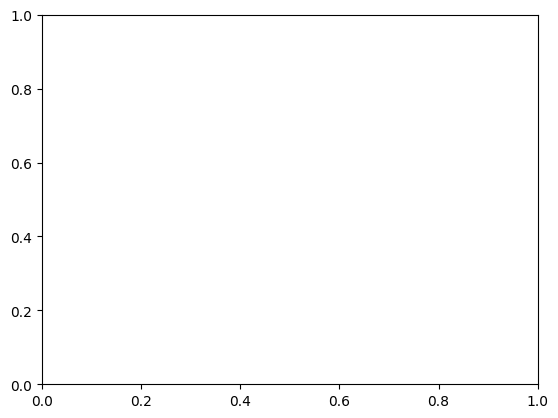

In [ ]:
# epochs = len(train_losses) // 5  # assuming same number of epochs for each fold
epochs = 50
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/final/kfold.keras")
# from tensorflow.keras.models import load_model
# model = load_model('kfold.keras')

In [ ]:
y_pred = model.predict(x_test)

13/13 [==============================] - 8s 255ms/step


In [ ]:
model.evaluate(x_test, y_test)

13/13 [==============================] - 3s 259ms/step - loss: 66.1011 - accuracy: 0.8029


[66.10107421875, 0.8028846383094788]